# Projet BAYES

In [1]:
import numpy as np
from scipy.special import binom
from scipy.stats import norm
import matplotlib.pyplot as plt

### Importation des données

Fichier de données originelles : 
```{r}
N <-
12
t <-
c(11, 11, 17, 22, 9, 6, 5, 14, 9, 7, 22, 51)
x <-
c(6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51)
y <-
c(5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0)
```

In [2]:
x = np.array([6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51])
y = np.array([5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0])
t = x + y
data = np.array((x, y, t)).T
data = np.array([tuple(t.tolist()) for t in data[:, :]], dtype=[("x", "<i4"), ("y", "<i4"), ("t", "<i4")])
data

array([( 6,  5, 11), ( 9,  2, 11), (17,  0, 17), (22,  0, 22),
       ( 7,  2,  9), ( 5,  1,  6), ( 5,  0,  5), (14,  0, 14),
       ( 9,  0,  9), ( 7,  0,  7), ( 9, 13, 22), (51,  0, 51)],
      dtype=[('x', '<i4'), ('y', '<i4'), ('t', '<i4')])

## Sans variable latentes

### Lois conditionelles

Lois des propositions

$$
\begin{flalign}
&P(y_i = 0 \mid t_i)  = \theta + (1 - \theta )(1 - p) ^ {t_i}&& \\
&P(y_i\mid t_i) = (1 - \theta) \binom{x_i + y_i}{y_i}p^{y_i}(1-p)^{x_i}, y_i \geq 1&& \\
&p = \dfrac{\beta}{1 + \beta}&&
\end{flalign}
$$


$$
\begin{flalign}
    P(p\mid \dots) &\propto \prod_{i=1}^n P(y_i \mid t_i) P(p)&&\\
    &\propto exp \left (-\dfrac{1}{2 \sigma^2}logit(p)^2 \right) \dfrac{1}{p (1-p)} \prod_{i=1}^n P(y_i \mid t_i)&& \\
    P(\theta \mid \dots) &\propto \prod_{i=1}^n P(y_i \mid t_i) P(\theta)&& \\
    &\propto exp \left (-\dfrac{1}{2 \sigma^2}logit(\theta)^2 \right) \dfrac{1}{\theta (1-\theta)} \prod_{i=1}^n P(y_i \mid t_i)&&
\end{flalign}
$$

In [3]:
sigma2 = 10**4

In [4]:
def logit(x):
    return np.log(x / (1-x))

def log_dens_p(p, data, theta):
    y, x, t = data["y"], data["x"], data["t"]
    # densité de p
    lp = -logit(p)**2 / (2 * sigma2) - np.log(p) -  np.log(1-p)
    # masse pour y_i == 0
    ly0 = np.sum(np.log(theta + (1-theta)*(1-p)**t[y==0]))
    # loi pour y_i >= 1
    lyg1 = np.sum(np.log(1-theta) + np.log(binom(t[y>=1], y[y>=1])) + y[y>=1] * np.log(p) + (t[y>=1]-y[y>=1])*np.log(1-p))
    return lp + ly0 + lyg1

def log_dens_theta(theta, data, p):
    y, x, t = data["y"], data["x"], data["t"]
    # densité de theta
    lt = -logit(theta)**2 / (2 * sigma2) - np.log(theta) - np.log(1-theta)
    # masse pour y_i == 0
    ly0 = np.sum(np.log(theta + (1-theta)*(1-p)**t[y==0]))
    # masse pour y_i >= 1
    lyg1 = np.sum(np.log(1-theta) + np.log(binom(t[y>=1], y[y>=1])) + y[y>=1] * np.log(p) + (t[y>=1]-y[y>=1])*np.log(1-p))
    return lt + ly0 + lyg1

### Sampler

Pour le noyau de proposition, on propose un simple noyau gaussien centré sur les valeurs actuelles de $\alpha$ et $\delta$, de même variation standard (obtenu par des essais à la main pour obtenir un bon taux de mélange). On propose nos candidats $\alpha_{prop}$ et $\delta_{prop}$, puis on calcule $p_{prop}$ et $\beta_{prop}$ associés, et on accepte ou rejette alors la proposition à partir des calculs de densité. Le noyau étant symétrique, il n'apparaît pas dans les calculs.

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def gibbs_hearts(nchain, data, init=None, std_dev=1, burning=0, stride=1):
    chain = np.zeros((burning+nchain, 2))
    acc_rate = np.zeros(2)
    if init is None:
        chain[0] = np.zeros(2)
    else:
        chain[0] = init

    for idx in range(1, burning + nchain):
        # Mise à jour de p
        X = np.copy(chain[idx-1])
        p = sigmoid(X[0])
        alpha_prop = norm.rvs(loc=X[0], scale=std_dev)
        p_prop = sigmoid(alpha_prop)
        acc = np.exp(log_dens_p(p_prop, data, sigmoid(X[1])) - log_dens_p(p, data, sigmoid(X[1])))

        u = np.random.uniform()
        if u <= acc:
            X[0] = alpha_prop
            if idx >= burning:
                acc_rate[0] += 1

        theta = sigmoid(X[1])
        delta_prop = norm.rvs(loc=X[1], scale=std_dev)
        theta_prop = sigmoid(delta_prop)
        acc = np.exp(log_dens_theta(theta_prop, data, sigmoid(X[0])) - log_dens_theta(theta, data, sigmoid(X[0])))

        u = np.random.uniform()
        if u <= acc:
            X[1] = delta_prop
            if idx >= burning:
                acc_rate[1] += 1
        
        chain[idx] = X

    beta = np.exp(chain[:, 0])
    theta = sigmoid(chain[:, 1])

    chain = np.array((chain[:, 0], beta, chain[:, 1], theta)).T
    chain = np.array([tuple(t.tolist()) for t in chain[:, :]],
                     dtype=[("alpha", "f8"), ("beta", "f8"), ("delta", "f8"), ("theta", "f8")])

    return chain[burning::stride], acc_rate / nchain

chain, acc_rate = gibbs_hearts(10**4, data, burning=1000, std_dev=1)
print(f"Taux d'acception en alpha : {acc_rate[0]}\nTaux d'acception en delta : {acc_rate[1]}")

Taux d'acception en alpha : 0.3278
Taux d'acception en delta : 0.5962


### Résultats

Résultats :
                mean        sd    median
alpha        -0.5075    0.2804   -0.5067
beta          0.6260    0.1778    0.6025
delta         0.3690    0.7033    0.3467
theta         0.5817    0.1535    0.5858



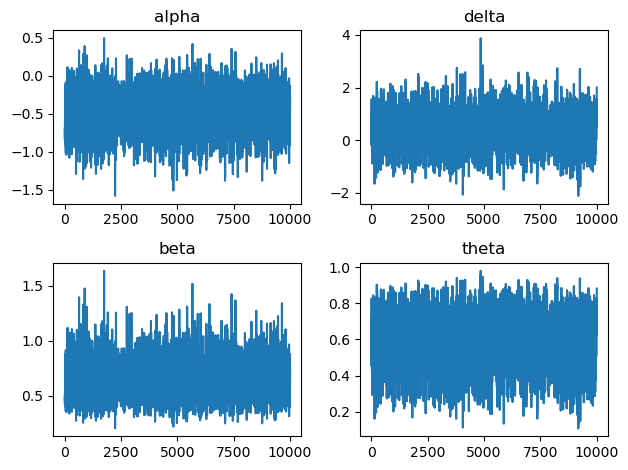

In [6]:
def report(data):
    res = "Résultats :\n"
    res += f"{"":>10}"
    res += f"{"mean":>10}"
    res += f"{"sd":>10}"
    res += f"{"median":>10}\n"
    for name in data.dtype.names:
        res += f"{name:10}"
        res += f"{np.mean(data[name]):10.4f}"
        res += f"{np.sqrt(np.var(data[name])):10.4f}"
        res += f"{np.median(data[name]):10.4f}\n"
    return res

print(report(chain))

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(chain["alpha"])
axs[0, 0].set_title("alpha")
axs[1, 0].plot(chain["beta"])
axs[1, 0].set_title("beta")
axs[0, 1].plot(chain["delta"])
axs[0, 1].set_title("delta")
axs[1, 1].plot(chain["theta"])
axs[1, 1].set_title("theta")
fig.tight_layout()
plt.savefig("figures/model1.png")

## Avec variables latentes

### Lois conditionnelles

Lois des propositions

$$
\begin{flalign}
P(y_i \mid Z_i, p) &\propto \mathbb 1_{Z_i=1} + \mathbb 1_{Z_i=0} \binom{x_i + y_i}{y_i} p^{y_i}(1-p)^{x_i}&&
\end{flalign}
$$

$$
\begin{flalign}
    P(p\mid \dots) &\propto \prod_{i=1}^n P(y_i \mid t_i) P(p)&&\\
    &\propto exp \left (-\dfrac{1}{2 \sigma^2}logit(p)^2 \right) \dfrac{1}{p (1-p)} \prod_{i=1}^n P(y_i \mid t_i)&&
\end{flalign}
$$

$$
\begin{flalign}
P(Z_i \mid \dots) &\propto P(y_i \mid Z_i, p) P(Z_i \mid \theta)&& \\
&\propto P(y_i, \mid Z_i, p) \theta^{Z_i} (1 - \theta)^{1 - Z_i}&&
\end{flalign}
$$

$$
\begin{flalign}
P(\theta \mid \dots) &\propto \prod_{i=1}P(Z_i \mid \theta) P(\theta)&& \\
&\propto \theta^{\sum_i Z_i} (1 - \theta)^{\sum_i 1 - Z_i} exp \left (-\dfrac{1}{2 \sigma^2}logit(\theta)^2 \right) \dfrac{1}{\theta (1-\theta)}&&
\end{flalign}
$$

In [7]:
def log_dens_p_latent(p, data, latent):
    y, x = data["y"], data["x"]
    # densité de p
    lp = -logit(p)**2 / (2 * sigma2) - np.log(p) -  np.log(1-p)
    # masse de y
    py = np.sum(y[latent==0]) * np.log(p) + np.sum(x[latent==0]) * np.log(1-p)
    return lp + py

def log_dens_theta_latent(theta, latent):
    # densité de theta
    lt = -logit(theta)**2 / (2 * sigma2) - np.log(theta) - np.log(1-theta)
    # masse des variables latentes
    cl = np.sum(latent==1)
    pt = cl * np.log(theta) + (len(latent) - cl) * np.log(1 - theta)
    return lt + pt

def log_dens_latent(latent, theta, p, data):
    y, x, t = data["y"], data["x"], data["t"]
    # masse due à y
    py = np.sum(np.log((latent == 1) * (y == 0) + (latent == 0) * (binom(t, y) * p ** y * (1-p)**x)))
    # masse de Z
    cl = np.sum(latent==1)
    pt = cl * np.log(theta) + (len(latent) - cl) * np.log(1 - theta)
    return pt + py

### Sampler

Pour $\alpha$ et $\delta$, on propose les mêmes noyaux et le même procédé.

On propose le noyau suivant pour les variables latentes :

On tire un i aléatoire parmi $\{i \mid Z_i = 1\}$. Puis on tire le nouvel état de $Z_i$ par $\mathcal Bern(1/2)$. Cela donne un noyau symétrique.

In [8]:
def gibbs_hearts_latent(nchain, data, init=None, std_dev=1, burning=0, stride=1):
    chain = np.zeros((burning+nchain, 2))
    acc_rate = np.zeros(3)
    if init is None:
        chain[0] = np.zeros(2)
    else:
        chain[0] = init
    latent_chain = np.zeros((burning+nchain, len(data["y"])))
    latent_chain[0] = data["y"] == 0

    for idx in range(1, burning + nchain):
        X = np.copy(chain[idx-1])
        # Mise à jour des variables latentes
        p = sigmoid(X[0])
        theta = 1/2
        latent = np.copy(latent_chain[idx-1])
        idx_prop = np.random.choice(np.nonzero(y == 0)[0])
        l = np.random.binomial(1, theta)
        latent_prop = np.copy(latent)
        latent_prop[idx_prop] = l
        acc = np.exp(log_dens_latent(latent_prop, theta, p, data) - log_dens_latent(latent, theta, p, data))
        u = np.random.uniform()
        if u <= acc:
            latent = latent_prop
            if idx >= burning:
                acc_rate[2] += 1
        
        # Mise à jour de p
        p = sigmoid(X[0])
        alpha_prop = norm.rvs(loc=X[0], scale=std_dev)
        p_prop = sigmoid(alpha_prop)
        acc = np.exp(log_dens_p_latent(p_prop, data, latent) - log_dens_p_latent(p, data, latent))

        u = np.random.uniform()
        if u <= acc:
            X[0] = alpha_prop
            if idx >= burning:
                acc_rate[0] += 1

        # Mise à jour de theta
        theta = sigmoid(X[1])
        delta_prop = norm.rvs(loc=X[1], scale=std_dev)
        theta_prop = sigmoid(delta_prop)
        acc = np.exp(log_dens_theta_latent(theta_prop, latent) - log_dens_theta_latent(theta, latent))

        u = np.random.uniform()
        if u <= acc:
            X[1] = delta_prop
            if idx >= burning:
                acc_rate[1] += 1
        
        chain[idx] = X
        latent_chain[idx] = latent

    beta = np.exp(chain[:, 0])
    theta = sigmoid(chain[:, 1])

    chain = np.array((chain[:, 0], beta, chain[:, 1], theta)).T
    chain = np.array([tuple(t.tolist()) for t in chain[:, :]], 
                     dtype=[("alpha", "f8"), ("beta", "f8"), ("delta", "f8"), ("theta", "f8")])

    dtype = [(f"patient {i+1}", np.float64) for i in range(12)]
    latent_chain = [tuple(col.tolist()) for col in latent_chain]
    latent_chain = np.array(latent_chain, dtype=dtype)

    return chain[burning::stride], acc_rate / nchain, latent_chain[burning::stride]

chain, acc_rate, latent = gibbs_hearts_latent(10**4, data, burning=1000, std_dev=0.5)
print(f"Taux d'acception en alpha : {acc_rate[0]}\nTaux d'acception en delta : {acc_rate[1]}\nTaux d'acception pour les variables latentes : {acc_rate[2]}")

Taux d'acception en alpha : 0.532
Taux d'acception en delta : 0.764
Taux d'acception pour les variables latentes : 0.5339


### Résultats

Paramètres de la chaîne
Résultats :
                mean        sd    median
alpha        -0.5071    0.2824   -0.4972
beta          0.6266    0.1789    0.6082
delta         0.3943    0.7280    0.3879
theta         0.5866    0.1569    0.5958

Guérison des patients (variable latente)
Résultats :
                mean        sd    median
patient 1     0.0000    0.0000    0.0000
patient 2     0.0000    0.0000    0.0000
patient 3     0.9967    0.0574    1.0000
patient 4     1.0000    0.0000    1.0000
patient 5     0.0000    0.0000    0.0000
patient 6     0.0000    0.0000    0.0000
patient 7     0.9051    0.2931    1.0000
patient 8     0.9950    0.0705    1.0000
patient 9     0.9804    0.1386    1.0000
patient 10    0.9500    0.2179    1.0000
patient 11    0.0000    0.0000    0.0000
patient 12    1.0000    0.0000    1.0000



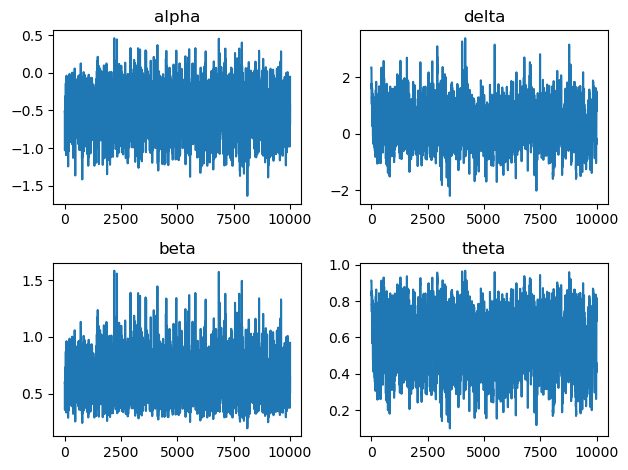

In [9]:
print("Paramètres de la chaîne")
print(report(chain))
print("Guérison des patients (variable latente)")
print(report(latent))
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(chain["alpha"])
axs[0, 0].set_title("alpha")
axs[1, 0].plot(chain["beta"])
axs[1, 0].set_title("beta")
axs[0, 1].plot(chain["delta"])
axs[0, 1].set_title("delta")
axs[1, 1].plot(chain["theta"])
axs[1, 1].set_title("theta")
fig.tight_layout()
plt.savefig("figures/model2.png")